In [4]:
import numpy as np

In [21]:
from PIL import Image
import sys
import os
import math
import numpy as np
import struct
from array import array
from os.path import join
from tqdm import tqdm
import random


# helper functions
def arr_from_img(im, shift=0):
    w, h = im.size
    c = im.getdata().bands
    return np.asarray(im.getdata(), dtype=np.float32).reshape((h, w, c)).transpose(2, 1, 0) / 255.0 - shift

def get_picture_array(X, index, shift=0):
    ch, w, h = X.shape[1], X.shape[2], X.shape[2]
    ret = ((X[index] + shift) * 255.0).reshape(ch, w, h).transpose(2, 1, 0).clip(0, 255).astype(np.uint8)
    if ch == 1:
        ret=ret.reshape(h, w)
    return ret

# loads mnist from web on demand
def read_images_labels(images_filepath="./train-images.idx3-ubyte", labels_filepath="./train-labels.idx1-ubyte"):
    labels = []
    with open(labels_filepath, 'rb') as file:
        magic, size = struct.unpack(">II", file.read(8))
        if magic != 2049:
            raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
        labels = array("B", file.read())

    with open(images_filepath, 'rb') as file:
        magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
        if magic != 2051:
            raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
        image_data = array("B", file.read())
    images = []
    for i in range(size):
        images.append([0] * rows * cols)
    for i in range(size):
        img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
        img = img.reshape(28, 28)
        images[i][:] = img
    
    return np.expand_dims(np.asarray(images), axis=1), np.asarray(labels)


# generates and returns video frames in uint8 array
def generate_moving_mnist(shape=(64, 64), 
                          seq_len=20, 
                          seqs=10000, 
                          num_sz=28, 
                          nums_per_image=2,
                          colored=True):
    class_converter = dict()
    k = 0
    for i in range(10):
        for j in range(i + 1):
            class_converter[j * 10 + i] = k
            k += 1

    mnist, labels = read_images_labels()
    height, width = shape
    lims = (x_lim, y_lim) = width-num_sz, height-num_sz
    if colored:
        dataset = np.empty((seqs, seq_len, 3, height, width), dtype=np.uint8)
    else:
        dataset = np.empty((seqs, seq_len, 1, height, width), dtype=np.uint8)
    ret_labels = []
    for seq_idx in tqdm(range(seqs)):
        # randomly generate direc/speed/position, calculate velocity vector
        direcs = np.pi * (np.random.rand(nums_per_image) * 2 - 1)
        speeds = np.random.randint(4, size=nums_per_image) + 2
        veloc = np.asarray([(v * math.cos(d), v * math.sin(d)) for d, v in zip(direcs, speeds)])
        cur_idx = np.random.randint(0, mnist.shape[0], nums_per_image)

        if colored:
            colors = [(random.random() / 4 * 3 + 0.25, random.random() / 4 * 3 + 0.25, random.random() / 4 * 3 + 0.25) \
                                                    for _ in range(nums_per_image)]
            
            mnist_images_arrays = [np.repeat(get_picture_array(mnist, r, shift=0)[None,:,:], 3, axis=0) \
                                               for ind, r in enumerate(cur_idx)]
            mnist_images_arrays_colored = [(img * np.array(colors[i])[:,None,None]).astype(np.uint8) \
                                               for i, img in enumerate(mnist_images_arrays)]
            mnist_images = [Image.fromarray(arr.transpose(2,1,0), mode="RGB") for arr in mnist_images_arrays_colored]
        else:
            mnist_images = [Image.fromarray(get_picture_array(mnist, r, shift=0)).resize((num_sz, num_sz), Image.LANCZOS) \
                   for r in cur_idx]
        
        # print(cur_idx)
        cur_labels = labels[cur_idx]
        ret_labels.append(class_converter[min(cur_labels) * 10 + max(cur_labels)])
        positions = np.asarray([(np.random.rand() * x_lim, np.random.rand() * y_lim) \
                                                for _ in range(nums_per_image)])
        for frame_idx in range(seq_len):
            canvases = [Image.new('RGB', (width, height), color=0) \
                                                for i in range(nums_per_image)]
            if colored:
                canvas = np.zeros((3, width, height), dtype=np.float32)
            else:
                canvas = np.zeros((1, width, height), dtype=np.float32)
            for i, canv in enumerate(canvases):
                canv.paste(mnist_images[i], tuple(np.round(positions[i]).astype(int)))
                
                canvas += arr_from_img(canv, shift=0)
            # update positions based on velocity
            next_pos = positions + veloc
            # bounce off wall if a we hit one
            for i, pos in enumerate(next_pos):
                for j, coord in enumerate(pos):
                    if coord < -2 or coord > lims[j] + 2:
                        veloc[i] = np.asarray(veloc[i][:j].tolist() + [-1 * veloc[i][j]] + veloc[i][j+1:].tolist())
            positions += veloc
            # copy additive canvas to data array
            dataset[seq_idx, frame_idx] = (canvas * 255).astype(np.uint8).clip(0, 255)
    return dataset, np.asarray(ret_labels)

def main(dest, filetype='npz', frame_size=64, seq_len=20, seqs=10000, 
                             num_sz=28, nums_per_image=2, colored=True):
    dat, labels = generate_moving_mnist(shape=(frame_size,frame_size), seq_len=seq_len, seqs=seqs, \
                                        num_sz=num_sz, nums_per_image=nums_per_image)
    n = seqs * seq_len
    if filetype == 'hdf5':
        import h5py
        from fuel.datasets.hdf5 import H5PYDataset
        def save_hd5py(dataset, destfile, indices_dict):
            f = h5py.File(destfile, mode='w')
            images = f.create_dataset('images', dataset.shape, dtype='uint8')
            images[...] = dataset
            split_dict = dict((k, {'images':v}) for k,v in indices_dict.iteritems())
            f.attrs['split'] = H5PYDataset.create_split_array(split_dict)
            f.flush()
            f.close()
        indices_dict = {'train': (0, n*9/10), 'test': (n*9/10, n)}
        save_hd5py(dat, dest, indices_dict)
    elif filetype == 'npz':
        np.save(join(dest, "videos.npy"), dat)
        np.save(join(dest, "labels.npy"), labels)
    elif filetype == 'jpg':
        for i in range(dat.shape[0]):
            Image.fromarray(get_picture_array(dat, i, shift=0)).save(join(dest, '{}.jpg'.format(i)))

In [83]:
main(dest="./ColoredMovingMNIST", 
     filetype='npz', 
     frame_size=40, 
     seq_len=20, 
     seqs=20, 
     num_sz=28, 
     nums_per_image=2,
     colored=True
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 35.10it/s]


In [84]:
all_videos = np.load("ColoredMovingMNIST/videos.npy")
video0 = all_videos[0]

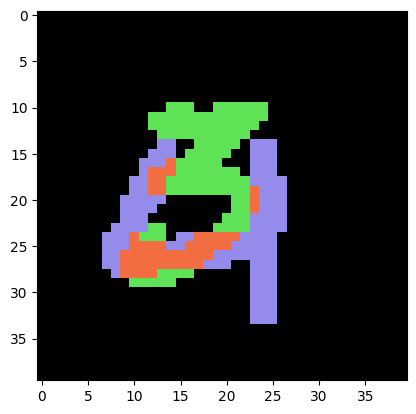

In [89]:
import matplotlib.pyplot as plt

plt.imshow(video0[0].transpose(2,1,0))